# Pedestrian Crash - Classification

## Read the dataset

I am reading the dataset from a file.
I've previously exported the dataset using another script.
The target will be one-hot-encoded. So from a vector of scalars, i have a vector of vectors.

## Importing the libraries

In [1]:
from pathlib import Path
from src.dataset_reader import DatasetReaderCSV
from src.utilities import to_scrollable_table
from src.plot import plot_car_attributes_onehot, plot_pedestrian_attributes, plot_hic_value, plot_validation_acc_values, plot_hic15_max_binned
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from keras.utils import to_categorical
from keras.layers import Dense, Dropout, BatchNormalization
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam


## Read the dataset

I am reading the dataset from a file.
I've previously exported the dataset using another script.

In [2]:
path = Path("C:\\Users\geork\projects\AIThesis\src\datasets\crash_simulation_classification.csv")
reader = DatasetReaderCSV(path)
reader.read()
df = reader.convert_to_dataframe()
df = df.drop(columns=["Position"], errors="ignore")

In [3]:
to_remove_features = ["Id", "Path",
                      "HIC36_max", 
                      "Head_Z_Acceleration_abs_max", "Head_X_Acceleration_abs_max", "Head_Y_Acceleration_abs_max",
                      "BrIC_abs_max", 
                      "Chest_Resultant_Acceleration_max", "Chest_Resultant_Acceleration_CLIP3ms_max"]
# Remove the unwanted columns
df = df.drop(columns=to_remove_features)

## Dataset Modifications

### One-hot-encoding in CarProfile column

In [4]:
# One-hot encoding the 'CarProfile' column
df['CarProfile_orig'] = df['CarProfile']

df = pd.get_dummies(df, columns=['CarProfile'])

# Display the DataFrame after one-hot encoding
print("\nDataFrame after One-hot Encoding:")
print(df)


DataFrame after One-hot Encoding:
      Velocity  Translation  Rotation  HIC15_max CarProfile_orig  \
0          100         -200         0     86.843             FCR   
1          100         -200       120   2361.697             FCR   
2          100         -200       150    573.455             FCR   
3          100         -200       180     84.702             FCR   
4          100         -200       210    592.965             FCR   
...        ...          ...       ...        ...             ...   
1195        80          400       300    623.367             SUV   
1196        80          400        30    140.360             SUV   
1197        80          400       330    367.018             SUV   
1198        80          400        60   1317.014             SUV   
1199        80          400        90   1861.807             SUV   

      CarProfile_FCR  CarProfile_MPV  CarProfile_RDS  CarProfile_SUV  
0               True           False           False           False  
1     

### Separate the HIC15_max column values into bin ranges from Q1 to Q8

In [5]:
NUM_OF_BINS = 8
# Create quantile bins
y_binned, bin_edges = pd.qcut(df['HIC15_max'], q=NUM_OF_BINS, labels=[f'Q{i+1}' for i in range(NUM_OF_BINS)], retbins=True)

# Print the ranges of the bins
print("Ranges for each quantile bin:")
for i in range(len(bin_edges) - 1):
    print(f"Q{i+1}: {bin_edges[i]} to {bin_edges[i+1]}")

# Add the binned variable as a new column to the DataFrame
df['HIC15_max_binned'] = y_binned
df = df.drop(columns=["HIC15_max"], errors="ignore")

# Now dfn_regr has the binned column
print(df.head())

# Print the count of each distinct value of HIC15_max_binned
print("\nCount of each distinct value of HIC15_max_binned:")
print(df['HIC15_max_binned'].value_counts().sort_index())

Ranges for each quantile bin:
Q1: 0.0 to 113.893625
Q2: 113.893625 to 444.45125
Q3: 444.45125 to 988.397375
Q4: 988.397375 to 1826.8964999999998
Q5: 1826.8964999999998 to 3490.965375
Q6: 3490.965375 to 7791.7429999999995
Q7: 7791.7429999999995 to 19452.69675
Q8: 19452.69675 to 277304.682
   Velocity  Translation  Rotation CarProfile_orig  CarProfile_FCR  \
0       100         -200         0             FCR            True   
1       100         -200       120             FCR            True   
2       100         -200       150             FCR            True   
3       100         -200       180             FCR            True   
4       100         -200       210             FCR            True   

   CarProfile_MPV  CarProfile_RDS  CarProfile_SUV HIC15_max_binned  
0           False           False           False               Q1  
1           False           False           False               Q5  
2           False           False           False               Q3  
3           Fa

### Expand CarProfiles to attributes

In [6]:
# Create the DataFrame
data = {
    'Front_Height': [770, 715, 880, 935],
    'Hood_Front_Width': [1160, 1080, 1100, 1388],
    'Hood_Back_Width': [1460, 1440, 1460, 1520],
    'Hood_Length': [1070, 1140, 870, 1105],
    'Hood_Angle': [11, 10, 12.3, 10],
    'Windscreen_Length': [816, 801, 930, 900],
    'Windscreen_Angle': [30, 27, 30, 31]
}

# New DataFrame with additional columns based on 'CarProfile'
index_labels = ['FCR', 'RDS', 'MPV', 'SUV']
attributes_df = pd.DataFrame(data, index=index_labels)

# Map the new columns to original_df based on 'CarProfile'
for col in attributes_df.columns:
    df[col] = df['CarProfile_orig'].map(attributes_df[col])

# Drop the 'CarProfile' column
# df = df.drop(columns=['CarProfile'])
df = df.drop(columns=["CarProfile_orig"])


## Dataset Insights

### Dataset Head

In [7]:
print(df.head())

   Velocity  Translation  Rotation  CarProfile_FCR  CarProfile_MPV  \
0       100         -200         0            True           False   
1       100         -200       120            True           False   
2       100         -200       150            True           False   
3       100         -200       180            True           False   
4       100         -200       210            True           False   

   CarProfile_RDS  CarProfile_SUV HIC15_max_binned  Front_Height  \
0           False           False               Q1           770   
1           False           False               Q5           770   
2           False           False               Q3           770   
3           False           False               Q1           770   
4           False           False               Q3           770   

   Hood_Front_Width  Hood_Back_Width  Hood_Length  Hood_Angle  \
0              1160             1460         1070        11.0   
1              1160             1460    

### Dataset description

In [8]:
print(df.describe())

          Velocity  Translation     Rotation  Front_Height  Hood_Front_Width  \
count  1200.000000  1200.000000  1200.000000   1200.000000       1200.000000   
mean     60.000000     0.000000   165.000000    825.000000       1182.000000   
std      28.296064   282.960637   103.604754     86.998893        122.574551   
min      20.000000  -400.000000     0.000000    715.000000       1080.000000   
25%      40.000000  -200.000000    82.500000    756.250000       1095.000000   
50%      60.000000     0.000000   165.000000    825.000000       1130.000000   
75%      80.000000   200.000000   247.500000    893.750000       1217.000000   
max     100.000000   400.000000   330.000000    935.000000       1388.000000   

       Hood_Back_Width  Hood_Length   Hood_Angle  Windscreen_Length  \
count      1200.000000  1200.000000  1200.000000        1200.000000   
mean       1470.000000  1046.250000    10.825000         861.750000   
std          30.012508   104.768003     0.944785          54.57719

### Dataset table

In [9]:
to_scrollable_table(df)

Velocity,Translation,Rotation,CarProfile_FCR,CarProfile_MPV,CarProfile_RDS,CarProfile_SUV,HIC15_max_binned,Front_Height,Hood_Front_Width,Hood_Back_Width,Hood_Length,Hood_Angle,Windscreen_Length,Windscreen_Angle
100,-200,0,True,False,False,False,Q1,770,1160,1460,1070,11.0,816,30
100,-200,120,True,False,False,False,Q5,770,1160,1460,1070,11.0,816,30
100,-200,150,True,False,False,False,Q3,770,1160,1460,1070,11.0,816,30
100,-200,180,True,False,False,False,Q1,770,1160,1460,1070,11.0,816,30
100,-200,210,True,False,False,False,Q3,770,1160,1460,1070,11.0,816,30
100,-200,240,True,False,False,False,Q4,770,1160,1460,1070,11.0,816,30
100,-200,270,True,False,False,False,Q6,770,1160,1460,1070,11.0,816,30
100,-200,300,True,False,False,False,Q6,770,1160,1460,1070,11.0,816,30
100,-200,30,True,False,False,False,Q3,770,1160,1460,1070,11.0,816,30
100,-200,330,True,False,False,False,Q2,770,1160,1460,1070,11.0,816,30


### Car profile attributes

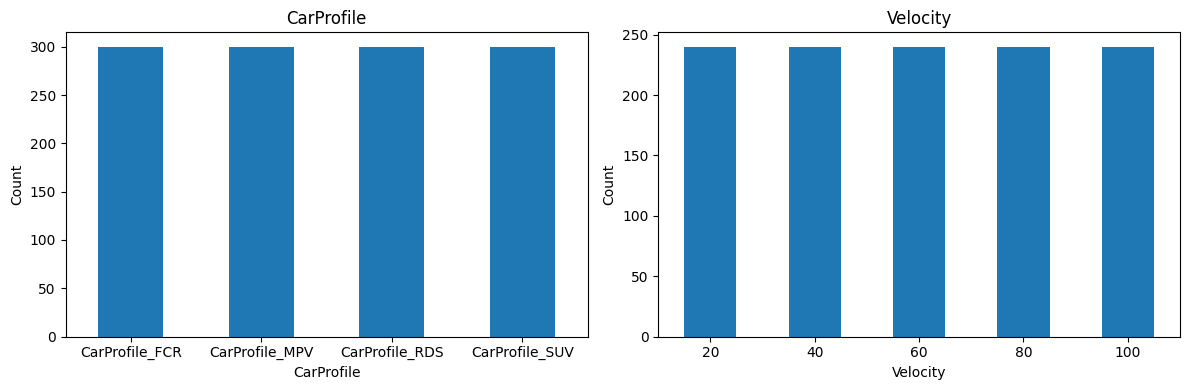

In [10]:
plot_car_attributes_onehot(df)

### Pedestrian attributes

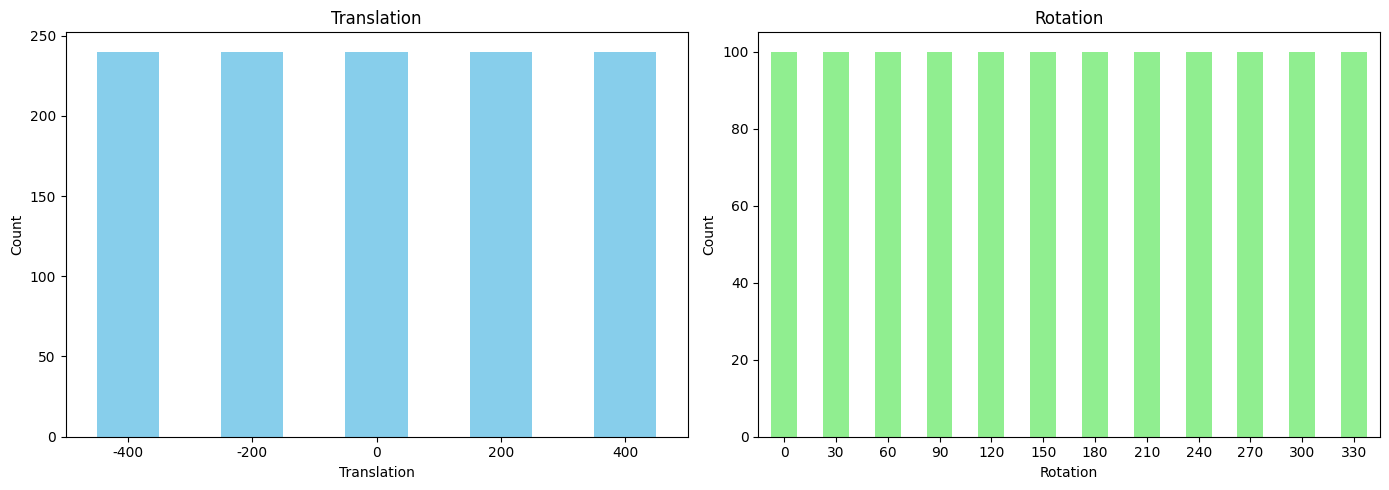

In [11]:
plot_pedestrian_attributes(df)

### Target attributes

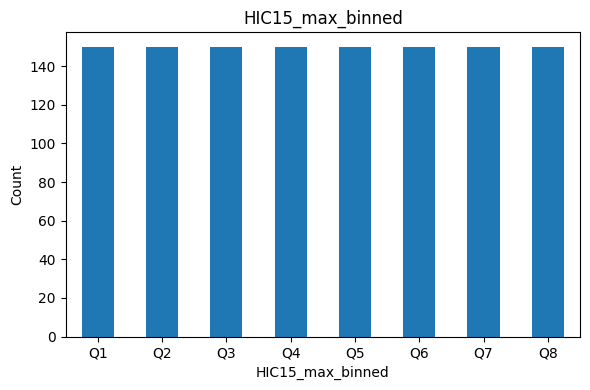

In [12]:
plot_hic15_max_binned(df)


## Perform classification on multiple targets

In [13]:
# Split the data into features and target
X = df.drop(columns=["HIC15_max_binned"])
y = df["HIC15_max_binned"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [15]:
# Encode target labels
label_encoder = LabelEncoder()
df['HIC15_max_binned'] = label_encoder.fit_transform(df['HIC15_max_binned'])

# Split features and target
X = df.drop(columns=['HIC15_max_binned'])
y = df['HIC15_max_binned']

# Convert boolean columns to integers
X = X.applymap(lambda x: int(x) if isinstance(x, bool) else x)

# One-hot encode the target labels
y = to_categorical(y)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



C:\Users\geork\AppData\Local\Temp\ipykernel_9740\3824699193.py:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X = X.applymap(lambda x: int(x) if isinstance(x, bool) else x)


## Classification: Approach #1

c:\Users\geork\projects\AIThesis\src\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/500
96/96 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.1791 - loss: 87.7371 - val_accuracy: 0.2500 - val_loss: 9.3614
Epoch 2/500
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2445 - loss: 9.2634 - val_accuracy: 0.2708 - val_loss: 5.8099
Epoch 3/500
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2277 - loss: 7.1615 - val_accuracy: 0.1792 - val_loss: 6.6236
Epoch 4/500
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.2362 - loss: 6.7983 - val_accuracy: 0.2292 - val_loss: 4.7964
Epoch 5/500
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2687 - loss: 5.2566 - val_accuracy: 0.3375 - val_loss: 4.2132
Epoch 6/500
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2575 - loss: 5.2469 - val_accuracy: 0.1583 - val_loss: 7.0615
Epoch 7/500
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2295 - loss: 5.9113 - val_accuracy: 0.3167 - val_loss: 4.2398
Epoch 8/500
96/96 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2414 - loss: 5.3820 - val_accuracy: 0.3292 -

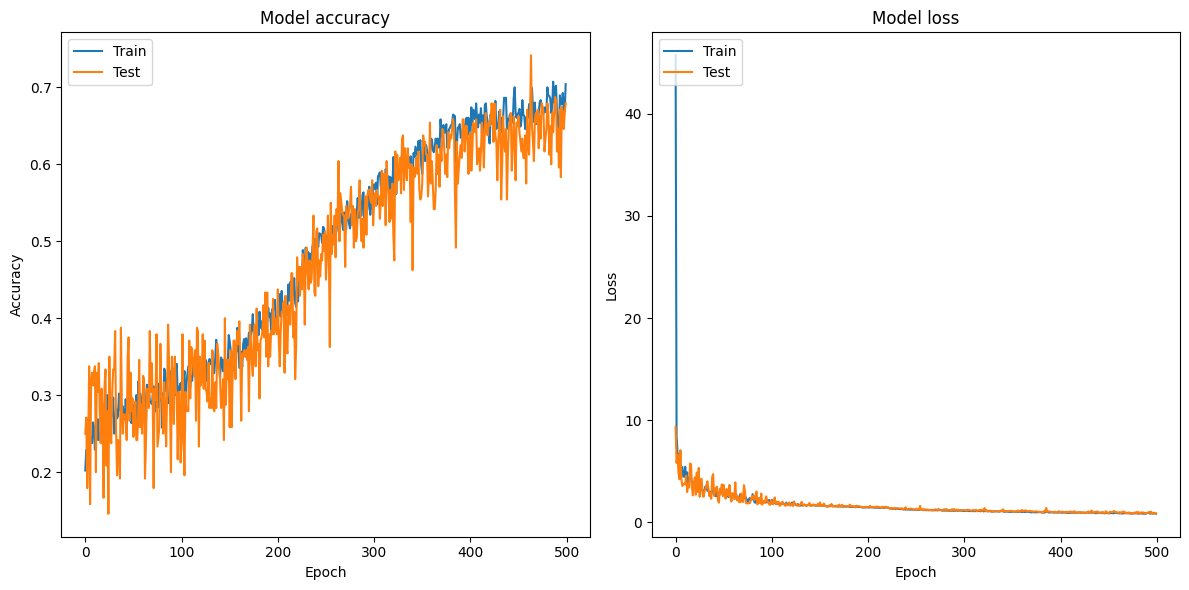

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


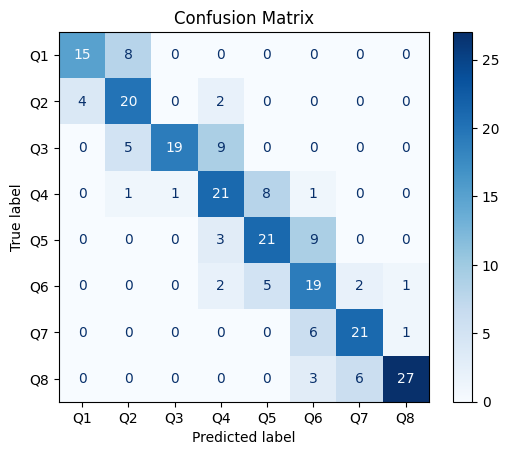

In [16]:
# Build and train the neural network model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Multi-class classification

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=500, batch_size=10, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

plot_validation_acc_values(history)

# Predict the classes of the test set
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

# Decode the one-hot encoded y_test to original labels for confusion matrix
y_test_classes = y_test.argmax(axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()


## Classification: Approach #2 - A little more complex network

c:\Users\geork\projects\AIThesis\src\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - accuracy: 0.1426 - loss: 2.6705 - val_accuracy: 0.1292 - val_loss: 9.1754
Epoch 2/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2556 - loss: 2.0335 - val_accuracy: 0.1125 - val_loss: 8.7782
Epoch 3/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2860 - loss: 1.8594 - val_accuracy: 0.1208 - val_loss: 7.1615
Epoch 4/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2910 - loss: 1.8651 - val_accuracy: 0.1083 - val_loss: 6.2818
Epoch 5/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2852 - loss: 1.8315 - val_accuracy: 0.1125 - val_loss: 5.3910
Epoch 6/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3147 - loss: 1.7404 - val_accuracy: 0.1250 - val_loss: 3.9664
Epoch 7/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3274 - loss: 1.7520 - val_accuracy: 0.1333 - val_loss: 3.1038
Epoch 8/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3193 - loss: 1.7216 - val_accuracy: 0.2000 

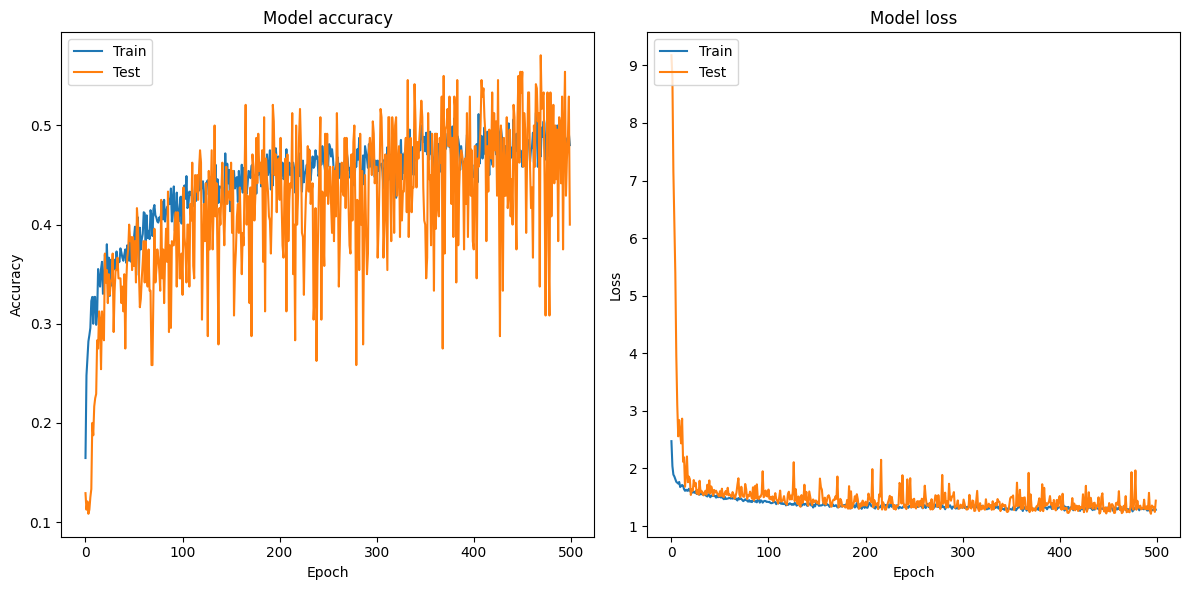

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


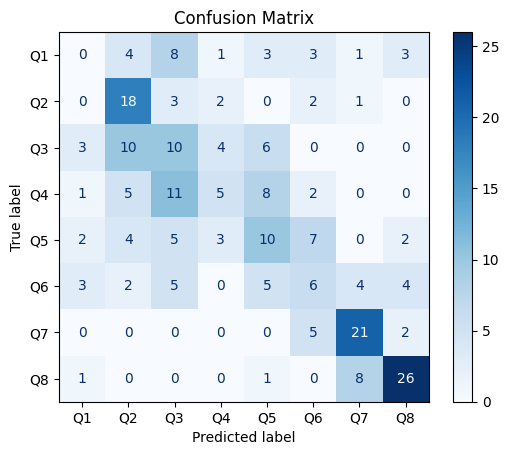

In [17]:
# Build and train the neural network model with modifications
model = Sequential()
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(64, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Multi-class classification

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Early stopping callback
#early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

# Train the model
#history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Accuracy: {accuracy * 100:.2f}%')

# Plot validation accuracy values
plot_validation_acc_values(history)

# Predict the classes of the test set
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)

# Decode the one-hot encoded y_test to original labels for confusion matrix
y_test_classes = y_test.argmax(axis=1)

# Generate the confusion matrix
cm = confusion_matrix(y_test_classes, y_pred_classes)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()